In [77]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
import nltk
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('portuguese')
from nltk.stem import SnowballStemmer
nltk.download('punkt')
stemmer = SnowballStemmer('portuguese')
import re
from unidecode import unidecode
from keras.regularizers import l2
from gensim.models import KeyedVectors
from tensorflow.keras import layers
from tensorflow.keras.losses import categorical_crossentropy
from keras.layers import Dense, Dropout, LSTM

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/augusto/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/augusto/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Pipeline 

In [29]:
# Base original da B2W, sem cortes + clean de overall_rating
b2wCorpus = pd.read_csv("B2W-Reviews01.csv",";",usecols=['review_text','overall_rating'])

# Filtro
d = b2wCorpus.index[b2wCorpus["overall_rating"] < 1].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])
d = b2wCorpus.index[b2wCorpus["overall_rating"] > 5].tolist()
b2wCorpus=b2wCorpus.drop(b2wCorpus.index[d])

print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  Estou contente com a compra entrega rápida o ú...
1                    4  Por apenas R$1994.20,eu consegui comprar esse ...
2                    4  SUPERA EM AGILIDADE E PRATICIDADE OUTRAS PANEL...
3                    4  MEU FILHO AMOU! PARECE DE VERDADE COM TANTOS D...
4                    5  A entrega foi no prazo, as americanas estão de...
...                ...                                                ...
132368               5  Vale muito, estou usando no controle do Xbox e...
132369               5  Prático e barato, super indico o produto para ...
132370               4  Chegou antes do prazo previsto e corresponde a...
132371               1  Material fraco, poderia ser melhor. Ficou deve...
132372               1  Comprei esse produto, quando chegou estava com...

[132373 rows x 2 columns]>


In [30]:
# Cleanning function
text_cleaning_re = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
def preprocess(text, stem=False):
  text = unidecode(text)
  text = re.sub(text_cleaning_re, ' ', str(text).lower()).strip()
  text = re.sub("\d+", "", text)
  text = re.sub(r'(?:^| )\w(?:$| )', ' ', text).strip()
  tokens = []
  for token in text.split():
    if token not in stop_words:
      if stem:
        tokens.append(stemmer.stem(token))
      else:
        tokens.append(token)
  return " ".join(tokens)

In [31]:
# Cleanning exec
b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: preprocess(x))

In [32]:
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    4  contente compra entrega rapida unico problema ...
1                    4        apenas consegui comprar lindo copo acrilico
2                    4  supera agilidade praticidade outras panelas el...
3                    4          filho amou parece verdade tantos detalhes
4                    5  entrega prazo americanas estao parabens smart ...
...                ...                                                ...
132368               5  vale usando controle xbox durou semana carga p...
132369               5  pratico barato super indico produto corre dia ...
132370               4    chegou antes prazo previsto corresponde anuncio
132371               1  material fraco poderia ser melhor ficou devend...
132372               1  comprei produto chegou avaria devolvi ja vai f...

[132373 rows x 2 columns]>


In [33]:
b2wCorpus.overall_rating .value_counts().sort_index()

1    27369
2     8389
3    16315
4    32345
5    47955
Name: overall_rating, dtype: int64

In [34]:
# Partilha
b2wCorpus = b2wCorpus.sample(frac=1).reset_index(drop=True)
print(b2wCorpus.head)

<bound method NDFrame.head of         overall_rating                                        review_text
0                    3  comprei produto justamente porque constava ada...
1                    4  otima qualidade bonita detalhe minimo potencia...
2                    1  liquidificador fraco nao liquidifica direito v...
3                    4   satisfeito produto barato livraria entregue casa
4                    3  gostei produto desempenha bem funcao aspirar a...
...                ...                                                ...
132368               5  gostei smartphone siuperou espectativas todos ...
132369               3      ficar claro dados produto exemplo tamanho etc
132370               1  liquidificador desse comprei aqui site pra pre...
132371               1  celular nao chego loja nao deu nenhuma explicacao
132372               1  caixa fogao veio aberta lacre empoeirada falta...

[132373 rows x 2 columns]>


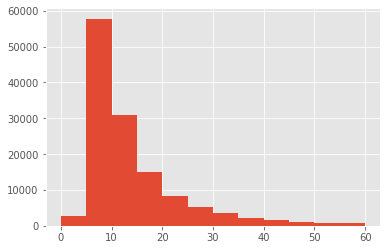

130344


In [35]:
# histograma de palavras x qtd de linhas
Words = [len(linha.split()) for linha in b2wCorpus["review_text"] if len(linha.split()) <=60 ]
plt.style.use('ggplot')
plt.hist(Words, bins=[0,5,10,15,20,25,30,35,40,45,50,55,60])
plt.show()
print(len(Words))

In [36]:
# Codifica
N =  200001
with open("cbow_s50.txt", "r",encoding='utf-8') as file:
    head = [next(file) for x in range(N)]

head[0] = str(N-1)+ " " + "50"+ "\n" # Conserta contagem de palavras
with open("word2vec_200k.txt", "w",encoding='utf-8') as file:
    for line in head:
        file.write(line)

def vocaIndex(lista, stem=False):
    for indice in range(len(lista)):
        text=lista[indice].lower()
        if text in model.vocab:
             lista[indice] = model.vocab[text].index
        else: 
             lista[indice] = '0'
    return lista

model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')

def codifica(text, stem=False):
    tokens = nltk.word_tokenize(text)
    tokens = vocaIndex(tokens)
    return tokens

b2wCorpus.review_text = b2wCorpus.review_text.apply(lambda x: codifica(x))

In [37]:
b2wCorpus['ord'] = b2wCorpus.apply(lambda row: len(row.review_text), axis=1)

In [38]:
b2wCorpus.shape

(132373, 3)

In [39]:
#b2wCorpus = b2wCorpus[b2wCorpus.ord != 0]
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord < 10].index)
b2wCorpus = b2wCorpus.drop(b2wCorpus[b2wCorpus.ord > 50].index)

In [40]:
b2wCorpus['overall_rating'] = b2wCorpus.overall_rating.apply(lambda x: x - 1)

In [41]:
b2wCorpus.shape

(60652, 3)

In [42]:
b2wCorpus.reset_index(drop=True, inplace=True)

In [43]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,2,"[9735, 902, 3392, 117, 20337, 41954, 6750, 173...",17
1,2,"[6376, 902, 9709, 70, 0, 28785, 102, 7804, 637...",13
2,0,"[90008, 7804, 2832, 2420, 62, 7804, 7256, 902,...",16
3,4,"[7804, 49798, 2104, 96, 1703, 52444, 6232, 553...",16
4,0,"[0, 902, 7804, 10650, 223, 223, 215, 4177, 780...",15


In [44]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [45]:
#b2wCorpus.review_text.str.rjust(width=50, fillchar='0')
#np.reshape(y_train,(-1))

b2wCorpus.review_text = keras.preprocessing.sequence.pad_sequences(b2wCorpus.apply(lambda row: np.reshape(row.review_text,(-1)), axis=1), maxlen=50, padding='post').tolist()

In [46]:
b2wCorpus.head()

,overall_rating,review_text,ord
0,2,"[9735, 902, 3392, 117, 20337, 41954, 6750, 173...",17
1,2,"[6376, 902, 9709, 70, 0, 28785, 102, 7804, 637...",13
2,0,"[90008, 7804, 2832, 2420, 62, 7804, 7256, 902,...",16
3,4,"[7804, 49798, 2104, 96, 1703, 52444, 6232, 553...",16
4,0,"[0, 902, 7804, 10650, 223, 223, 215, 4177, 780...",15


In [47]:
# Função de split
def train_validate_test_split(df, train_percent=.65, validate_percent=.1, seed=42):
    np.random.seed(seed)
    perm = np.random.permutation(df.index)
    m = len(df.index)
    train_end = int(train_percent * m)
    validate_end = int(validate_percent * m) + train_end
    train = df.iloc[perm[:train_end]]
    validate = df.iloc[perm[train_end:validate_end]]
    test = df.iloc[perm[validate_end:]]
    return train, validate, test

In [48]:
b2wCorpusTrain, b2wCorpusValidate, b2wCorpusTest = train_validate_test_split(b2wCorpus)

In [49]:
b2wCorpusTrain=b2wCorpusTrain.reindex(b2wCorpusTrain['ord'].sort_values(ascending=False).index)
b2wCorpusTrain.head()

,overall_rating,review_text,ord
47520,3,"[2989, 61637, 226, 13132, 1108, 363, 43996, 10...",30
43818,3,"[3006, 70, 45736, 2694, 7804, 54534, 16949, 32...",30
12508,0,"[9735, 275, 0, 1104, 8837, 5059, 245, 9735, 90...",30
19495,0,"[902, 615, 616, 8570, 1126, 6943, 32617, 71778...",30
36128,4,"[6376, 323, 1850, 3281, 93, 0, 0, 93, 33470, 5...",30


In [50]:
b2wCorpusValidate=b2wCorpusValidate.reindex(b2wCorpusValidate['ord'].sort_values(ascending=False).index)
b2wCorpusValidate.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
25622               4  [0, 2499, 171, 100, 1094, 377, 2601, 7157, 685...   30
56540               0  [3093, 15908, 13567, 2423, 199404, 902, 8852, ...   30
9191                0  [36296, 12783, 9735, 5437, 6054, 439, 194, 166...   30
6490                0  [873, 9235, 902, 516, 4086, 12138, 19726, 1278...   30
58475               0  [9735, 78, 338, 11264, 6045, 872, 24318, 202, ...   30
...               ...                                                ...  ...
1373                3  [902, 428, 70, 131, 566, 363, 199404, 323, 195...   10
45012               4  [16476, 902, 3330, 13234, 7978, 2499, 131, 132...   10
22205               4  [902, 428, 104, 3993, 1083, 7794, 2104, 902, 2...   10
31668               2  [2697, 2722, 1135, 1253, 981, 327, 1314, 1253,...   10
52755               2  [116662, 1879, 1130, 751, 226, 16466, 532, 166...   10

[6065 rows x 3 columns]>

In [51]:
b2wCorpusTest=b2wCorpusTest.reindex(b2wCorpusTest['ord'].sort_values(ascending=False).index)
b2wCorpusTest.head

<bound method NDFrame.head of        overall_rating                                        review_text  ord
49688               4  [7968, 62, 532, 138, 39, 0, 134, 627, 121, 156...   30
8635                1  [902, 7804, 20465, 0, 290, 7804, 29495, 3144, ...   30
30151               4  [6376, 902, 37822, 7856, 8721, 8129, 467, 7804...   30
46576               2  [0, 0, 3974, 9854, 101071, 1602, 25764, 2420, ...   30
33505               0  [0, 1681, 70, 981, 310, 0, 0, 825, 2274, 2142,...   30
...               ...                                                ...  ...
48217               4  [2104, 0, 2499, 131, 566, 231, 112734, 14911, ...   10
43039               2  [902, 226, 363, 532, 0, 0, 0, 1101, 226, 4853,...   10
37823               4  [2499, 1177, 321, 566, 1312, 19672, 2104, 532,...   10
52817               0  [667, 31085, 7804, 440, 290, 18874, 86, 7804, ...   10
7377                4  [508, 226, 7668, 0, 0, 161274, 1959, 43308, 16...   10

[15164 rows x 3 columns]>

In [52]:
type(b2wCorpus.review_text)

pandas.core.series.Series

In [53]:
# Treino, Validação e teste
RANDOM_SEED = 42
x_train =  [ emb for emb in b2wCorpusTrain.review_text]
y_train =   b2wCorpusTrain.overall_rating
x_val = [ emb for emb in b2wCorpusValidate.review_text ]
y_val = b2wCorpusValidate.overall_rating
x_train = np.asarray(x_train)
x_val =np.asarray(x_val)

np.random.seed(RANDOM_SEED)
model = KeyedVectors.load_word2vec_format('word2vec_200k.txt')
emb = model.get_keras_embedding()


In [78]:
from tensorflow.keras.losses import sparse_categorical_crossentropy
SEQUENCE_MAXLEN = 50
model = keras.Sequential()
model.add(layers.Input(shape=(SEQUENCE_MAXLEN, )))
model.add(emb)
model.add(layers.LSTM(128, activation='relu',return_sequences=True))
model.add(Dropout(0.2))
model.add(keras.layers.LSTM(128, activation='relu'))
model.add(Dropout(0.2))
model.add(keras.layers.Dense(32, activation='relu'))
model.add(Dropout(0.2))
model.add(keras.layers.Dense(5, activation='softmax'))
#opt = tf.keras.optimizers.SGD(learning_rate=.1, momentum=.5)
#opt = tf.keras.optimizers.Adamax(learning_rate=0.01, beta_1=.9, beta_2=.9, epsilon=1e-07, name="Adamax")
#model.compile(optimizer=opt, loss=categorical_crossentropy, metrics=['acc', 'mae'])
opt="adam"
model.compile(optimizer=opt,loss=sparse_categorical_crossentropy, metrics=["accuracy"])
history = model.fit(
    x= x_train, y=y_train, batch_size=128, epochs=50, validation_data=(x_val, y_val)
)

Epoch 1/50
308/308 [==============================] - 12s 39ms/step - loss: 1.2599 - accuracy: 0.4856 - val_loss: 1.1657 - val_accuracy: 0.5202
Epoch 2/50
308/308 [==============================] - 12s 38ms/step - loss: 1.1390 - accuracy: 0.5333 - val_loss: 1.0859 - val_accuracy: 0.5558
Epoch 3/50
308/308 [==============================] - 11s 37ms/step - loss: 1.0799 - accuracy: 0.5548 - val_loss: 1.0552 - val_accuracy: 0.5713
Epoch 4/50
308/308 [==============================] - 12s 39ms/step - loss: 1.0515 - accuracy: 0.5679 - val_loss: 1.0408 - val_accuracy: 0.5733
Epoch 5/50
308/308 [==============================] - 12s 38ms/step - loss: 1.0338 - accuracy: 0.5743 - val_loss: 1.0292 - val_accuracy: 0.5758
Epoch 6/50
267/308 [=========================>....] - ETA: 1s - loss: 1.0198 - accuracy: 0.5784

KeyboardInterrupt: 

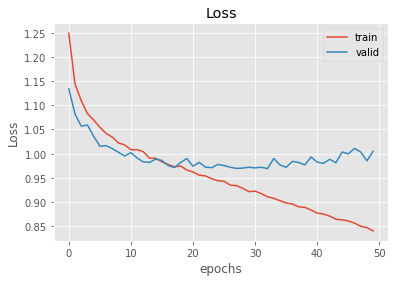

In [68]:
plt.title('Loss')
plt.xlabel('epochs')
plt.ylabel('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.legend()
plt.show();

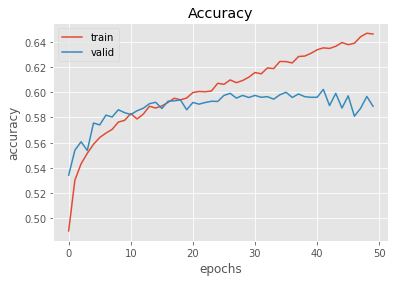

In [69]:
plt.title('Accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='valid')
plt.legend()
plt.show();